# Progressive GANS 


This is a Progressive GANS model inspired by https://research.nvidia.com/publication/2017-10_Progressive-Growing-of

In [0]:
# https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

from __future__ import print_function
import argparse
import os
import glob
import shutil
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torch.utils.tensorboard import SummaryWriter

import torchvision

import torchvision.datasets as dset
from torch.utils.data import Dataset

import torchvision.transforms as transforms
import torchvision.utils as vutils

%matplotlib inline

In [2]:
# mounts the google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Parameters

In [0]:
# images
MODEL_PTH = '/content/drive/My Drive/repos/art_generator/data_out/saved_models/anime_32/'
IMG_SIZE = 32
N_CHANNELS = 3

# graph
GEN_INPUT_SIZE = 100
N_LAYERS = int(np.log(IMG_SIZE) / np.log(2)) - 1
N_GEN_CHANNELS = 128
N_DISC_CHANNELS = 128
beta1 = 0.5
BATCH_SIZE = 16
ngpu = 1

## Data Setup

### Dataset

### Cuda Device

In [0]:
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

## Model Setup

### Generator

In [0]:
class Generator(nn.Module):
    def __init__(self, ngpu, n_layers):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.n_layers = n_layers

        self.layers = nn.ModuleList([nn.ConvTranspose2d(GEN_INPUT_SIZE, N_GEN_CHANNELS * 2, 4, 1, 0, bias=False)])
        self.layers.extend([nn.ConvTranspose2d(N_GEN_CHANNELS * 2, N_GEN_CHANNELS * 2, 4, 2, 1, bias=False) for i in range(self.n_layers - 3)])
        self.layers.extend([nn.ConvTranspose2d(N_GEN_CHANNELS * 2, N_GEN_CHANNELS, 4, 2, 1, bias=False),
                            nn.ConvTranspose2d(N_GEN_CHANNELS, N_CHANNELS, 4, 2, 1, bias=False)])                   
                           
        self.batch1 = nn.BatchNorm2d(N_GEN_CHANNELS)
        self.batch2 = nn.BatchNorm2d(N_GEN_CHANNELS * 2)

        self.relu = nn.ReLU(True)
        self.tanh = nn.Tanh()

    def forward(self, x):
        for i, name in enumerate(self.layers):
            x = self.layers[i](x)

            if self.layers[i].out_channels == N_GEN_CHANNELS * 2:
                x = self.batch2(x)
                x = self.relu(x)
            elif self.layers[i].out_channels == N_GEN_CHANNELS:
                x = self.batch1(x)
                x = self.relu(x)
            else:
                x = self.tanh(x)

        return x

In [6]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Create the generator
netG = Generator(ngpu, N_LAYERS).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

Generator(
  (layers): ModuleList(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): ConvTranspose2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (2): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (batch1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (tanh): Tanh()
)

### Loss Functions and Optimizers

In [0]:
# # Initialize BCELoss function
# criterion = nn.BCELoss()

# # Create batch of latent vectors that we will use to visualize
# #  the progression of the generator
# fixed_noise = torch.randn(64, GEN_INPUT_SIZE, 1, 1, device=device)

# # Establish convention for real and fake labels during training
# real_label = 1
# fake_label = 0

# # # Setup Adam optimizers for both G and D
# # optimizerG = optim.Adam(netG.parameters(), lr=LR, betas=(beta1, 0.999))

### Loads Checkpoint

In [8]:
# loads the model weights
checkpoint = torch.load(MODEL_PTH + 'checkpoint.pt')
netG.load_state_dict(checkpoint['netG_state'])

<All keys matched successfully>

## Results

### Random Image

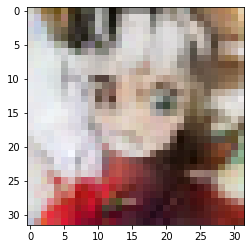

In [9]:
# helper function for converting images to a normal range
def img_scale(img_tensor):
    min_value = img_tensor.min()
    span = img_tensor.max() - img_tensor.min()
    img_tensor = (img_tensor - min_value) / span
    img_tensor = np.transpose(img_tensor)
    img_tensor = torch.transpose(img_tensor, 0, 1)

    return img_tensor


# real_cpu = data[0].to(device)
# b_size = real_cpu.size(0)
b_size = 2

noise = torch.randn(b_size, GEN_INPUT_SIZE, 1, 1, device=device)
output = netG(noise).detach().cpu()
plt.imshow(img_scale(output[0]))